Importing Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from glob import glob

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Reading images

In [4]:
folders=sorted(glob("/home/saab/Desktop/oculus_read*"))
folders

['/home/saab/Desktop/oculus_read_20250205_180454 1',
 '/home/saab/Desktop/oculus_read_20250205_180647 1']

In [5]:
images=sorted(glob(folders[1]+"/*.png"))
images

['/home/saab/Desktop/oculus_read_20250205_180647 1/0000.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0001.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0002.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0003.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0004.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0005.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0006.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0007.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0008.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0009.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0010.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0011.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0012.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0013.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0014.png',
 '/home/saab/Desktop/oculus_read_20250205_180647 1/0015.png',
 '/home/

You can directly input CFAR filtered images here instead of running the cell below

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

from scipy.optimize import root

def soca(img, train_hs, guard_hs, tau):
  print(train_hs)
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)


  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.min([leading_sum, lagging_sum])
      ret[row, col] = (tau * sum_train / train_hs)

  return ret

def goca(img, train_hs, guard_hs, tau):
  """
  Implements Sum-Oriented Constant Amplitude filter based on NumPy.

  Args:
    img: Input image as a NumPy array (assumed to be BGR or grayscale).
    train_hs: Training window half-size.
    guard_hs: Guard window half-size.
    tau: Threshold parameter.

  Returns:
    A 2D NumPy array with filtered binary image.
  """

  # Convert OpenCV image to NumPy array and grayscale (if necessary)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
  blurred_image = cv2.GaussianBlur(img_gray, (7, 7), 0)
  denoised_image = cv2.fastNlMeansDenoising(blurred_image, h=200)

  rows, cols = denoised_image.shape
  ret = np.zeros((rows, cols), dtype=np.uint8)

  for col in range(cols):
    for row in range(train_hs + guard_hs, rows - train_hs - guard_hs):
      leading_sum, lagging_sum = 0.0, 0.0
      for i in range(row - train_hs - guard_hs, row + train_hs + guard_hs + 1):
        if (i - row) > guard_hs:
          lagging_sum += denoised_image[i, col]
        else:
          leading_sum += denoised_image[i, col]
      sum_train = np.max([leading_sum, lagging_sum])
      ret[row, col] = ((tau * sum_train / train_hs))

  return ret
class CFAR(object):
      """
      Constant False Alarm Rate (CFAR) detection with several variants
          - Cell averaging (CA) CFAR
          - Greatest-of cell-averaging (GOCA) CFAR
          - Order statistic (OS) CFAR
      """

      def __init__(self, Ntc, Ngc, Pfa, rank=None):
          self.Ntc = Ntc #number of training cells
          assert self.Ntc % 2 == 0
          self.Ngc = Ngc #number of guard cells
          assert self.Ngc % 2 == 0
          self.Pfa = Pfa #false alarm rate
          if rank is None: #matrix rank
              self.rank = self.Ntc / 2
          else:
              self.rank = rank
              assert 0 <= self.rank < self.Ntc

          #threshold factor calculation for the 4 variants of CFAR
          self.threshold_factor_SOCA = self.calc_WGN_threshold_factor_SOCA()
          self.threshold_factor_GOCA = self.calc_WGN_threshold_factor_GOCA()


          self.params = {
              
              "SOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_SOCA),
              "GOCA": (self.Ntc // 2, self.Ngc // 2, self.threshold_factor_GOCA),

          }
          self.detector = {
              
              "SOCA": soca,
              "GOCA": goca,
          
          }
        

      def __str__(self):
          return "".join(
              [
                  "CFAR Detector Information\n",
                  "=========================\n",
                  "Number of training cells: {}\n".format(self.Ntc),
                  "Number of guard cells: {}\n".format(self.Ngc),
                  "Probability of false alarm: {}\n".format(self.Pfa),
                  "Order statictics rank: {}\n".format(self.rank),
                  "Threshold factors:\n",
                
                  "    SOCA-CFAR: {:.3f}\n".format(self.threshold_factor_SOCA),
                  "    GOCA-CFAR: {:.3f}\n".format(self.threshold_factor_GOCA),
          
              ]
          )

      def calc_WGN_threshold_factor_CA(self):
          return self.Ntc * (self.Pfa ** (-1.0 / self.Ntc) - 1)

      def calc_WGN_threshold_factor_SOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_SOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of SOCA not found")

      def calc_WGN_threshold_factor_GOCA(self):
          x0 = self.calc_WGN_threshold_factor_CA()
          for ratio in np.logspace(-2, 2, 10):
              ret = root(self.calc_WGN_pfa_GOCA, x0 * ratio)
              if ret.success:
                  return ret.x[0]
          raise ValueError("Threshold factor of GOCA not found")

      def calc_WGN_pfa_GOSOCA_core(self, x):
          x = float(x)
          temp = 0.0
          for k in range(int(self.Ntc / 2)):
              l1 = math.lgamma(self.Ntc / 2 + k)
              l2 = math.lgamma(k + 1)
              l3 = math.lgamma(self.Ntc / 2)
              temp += math.exp(l1 - l2 - l3) * (2 + x / (self.Ntc / 2)) ** (-k)
          return temp * (2 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)

      def calc_WGN_pfa_SOCA(self, x):
          return self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2

      def calc_WGN_pfa_GOCA(self, x):
          x = float(x)
          temp = (1.0 + x / (self.Ntc / 2)) ** (-self.Ntc / 2)
          return temp - self.calc_WGN_pfa_GOSOCA_core(x) - self.Pfa / 2


      def detect(self, mat, alg="CA"):
          """
          Return target mask array.
          """
          #pad_width = [(self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2), (self.Ntc//2 + self.Ngc//2, self.Ntc//2 + self.Ngc//2)]
          #mat=np.pad(mat, pad_width=pad_width, mode='constant', constant_values=0)
          return self.detector[alg](mat, *self.params[alg])

def soca_code(soca_trial):

  # img_gray=cv2.imread("test.png",0)
  img = soca_trial
  cfar_obj=CFAR(6,2,0.95) 

  cfar_result=cfar_obj.detect(img,alg="SOCA")
  return cfar_result 

Sanity checks --> Checking thresholding results with 1/2 images

/tmp/ipykernel_3334402/4065414015.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_3334402/4065414015.py:168: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


3


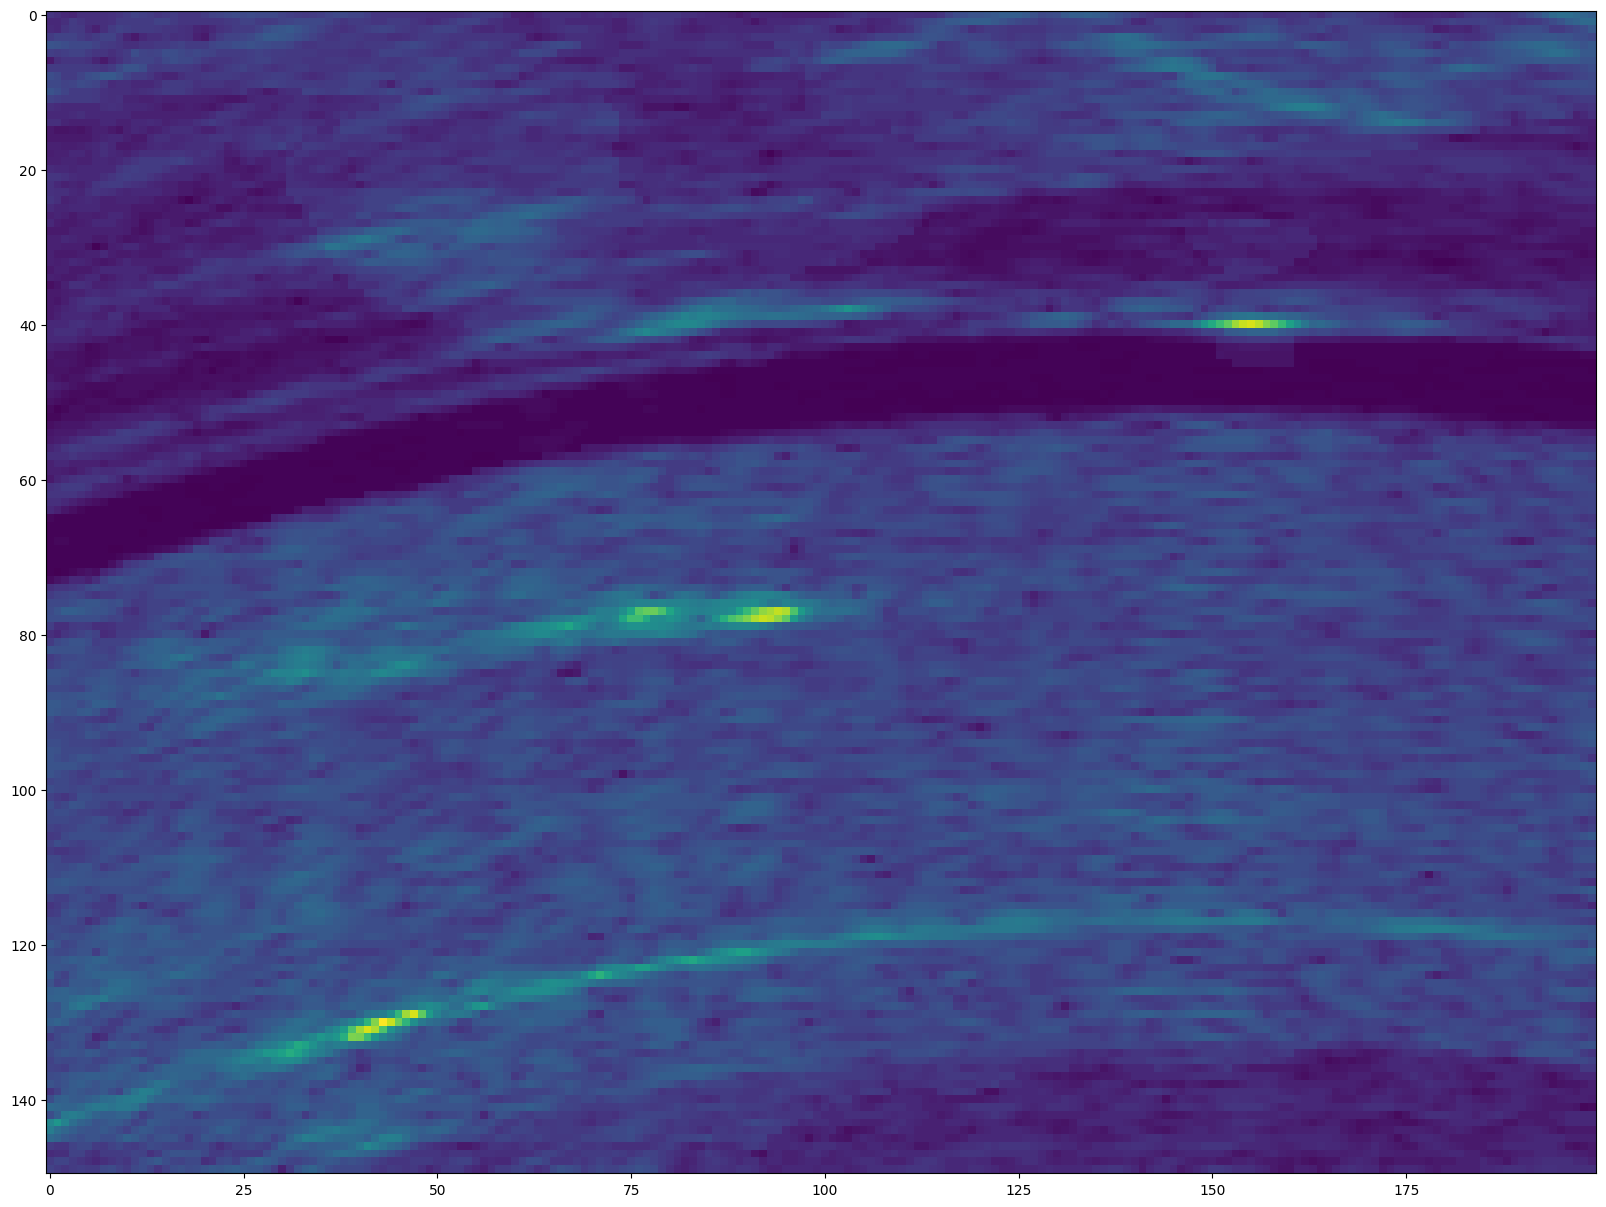

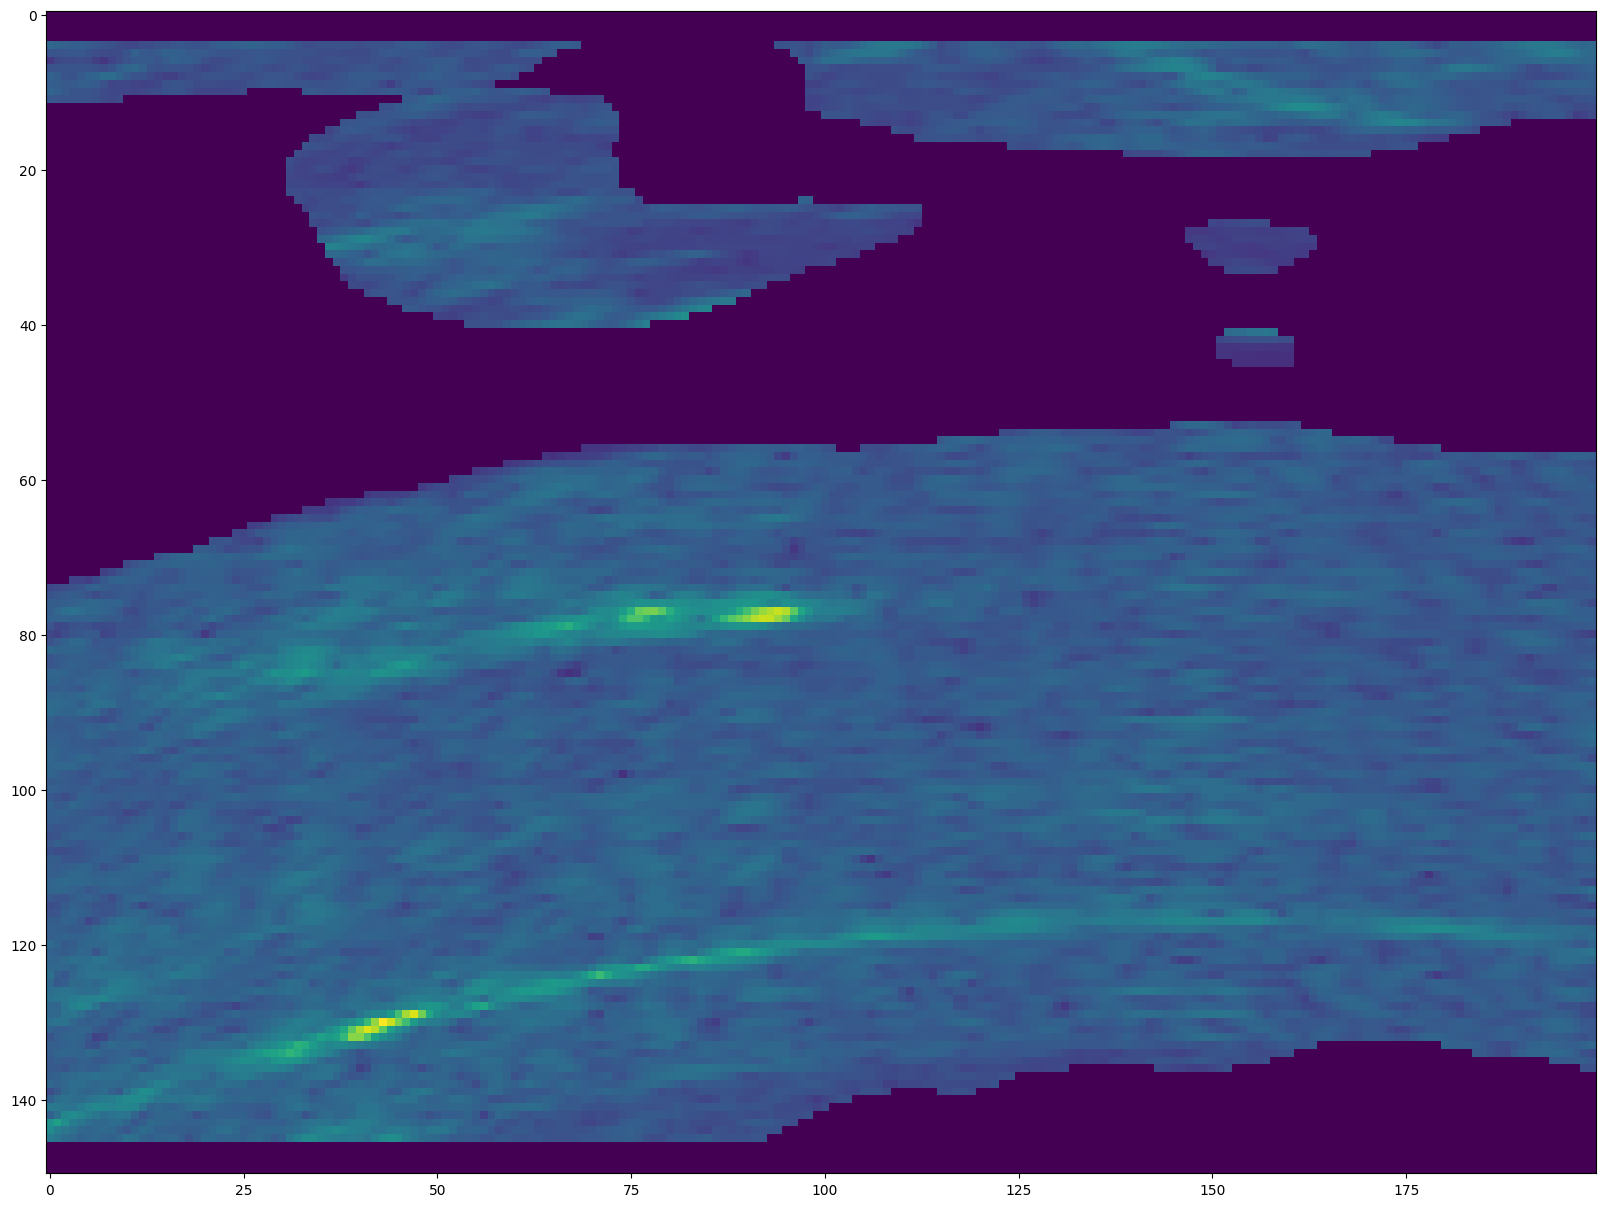

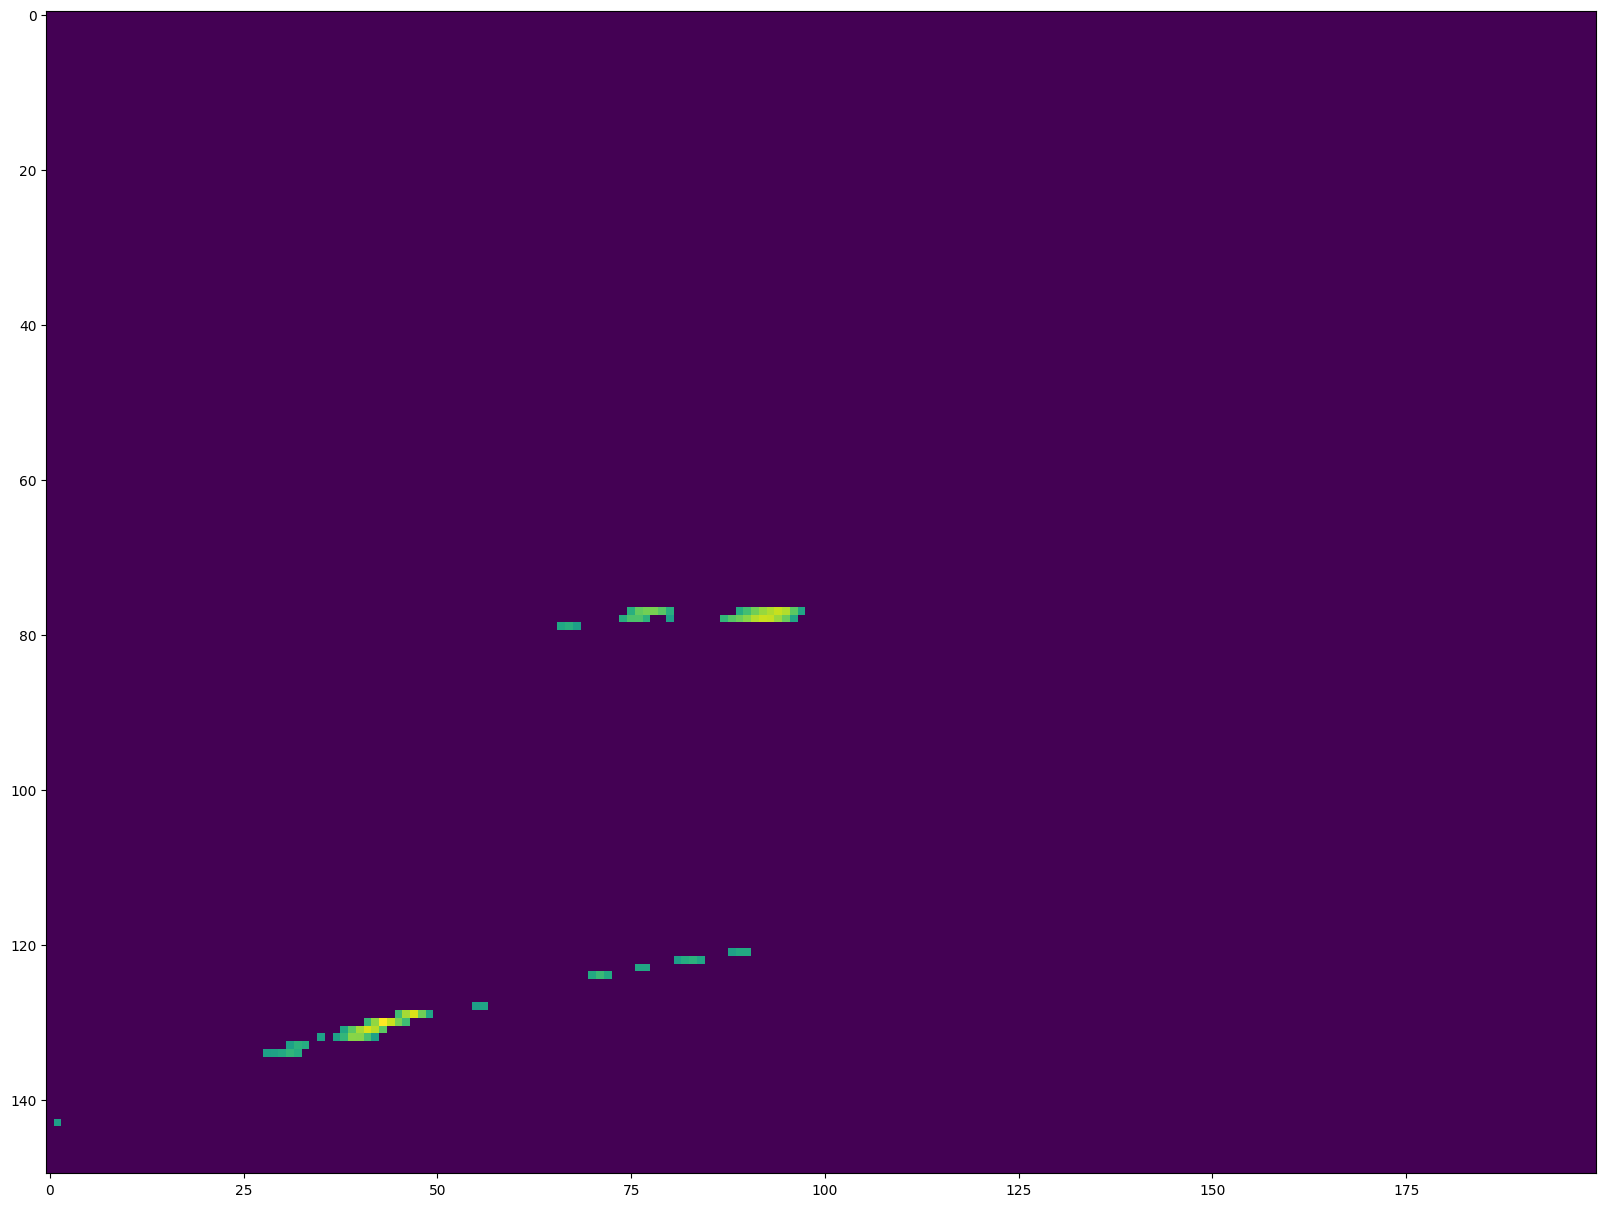

In [300]:
for img_path in range(0,len(images),2):
    img=cv2.imread(images[img_path],0)
plt.figure(figsize=(20,20))
x=img[150:300,200:400]
y=soca_code(x)
plt.imshow(y)
vals_arr=np.unique(y)
r,t=cv2.threshold(y,np.max(vals_arr)//2,np.max(vals_arr),cv2.THRESH_BINARY)
plt.imshow(cv2.addWeighted(t,0.75,x,0.5,0))
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(x*(t//np.max(t)))
r,t2=cv2.threshold(x*(t//np.max(t)),120,255,cv2.THRESH_BINARY)
plt.figure(figsize=(20,20))
plt.imshow(x*(t2//np.max(t2)))

For 5th Feb dataset, not sure if applicable for 12th Feb dataset, CFAR was too strong, hence binary thresholding helped

In [7]:
filtered_fls_images=[]
raw_images=[]
for img_path in range(0,220):
    img=cv2.imread(images[img_path],0)
    #r,t=cv2.threshold(img,150,255,cv2.THRESH_BINARY)
    #plt.figure(figsize=(20,5))
    x=img[150:300,200:400]
    y=soca_code(x)
    #plt.imshow(y)
    vals_arr=np.unique(y)
    r,t=cv2.threshold(y,np.max(vals_arr)//1.85,np.max(vals_arr),cv2.THRESH_BINARY)
    #plt.imshow(cv2.addWeighted(t,0.75,x,0.5,0))
    #plt.show()
    #plt.figure(figsize=(20,5))
    #plt.imshow(x*(t//np.max(t)))
    r,t2=cv2.threshold(x*(t//np.max(t)),120,255,cv2.THRESH_BINARY)
    #plt.figure(figsize=(20,5))
    #plt.imshow(x*(t2//np.max(t2)))
    
    raw_images.append(x)
    filtered_fls_images.append(x*(t2//np.max(t2)))
#for x,y in zip(raw_images,filtered_fls_images):
#    view=np.hstack([x,y])
#    plt.imshow(view)
#    plt.show()    

/tmp/ipykernel_3457495/4065414015.py:155: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)
/tmp/ipykernel_3457495/4065414015.py:168: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(x)


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


Some ideas --> Spacing out point cloud with zero height point clouds to improve visualization quality

In [8]:

z=0
point_clouds=[]
i=0
for img in filtered_fls_images:
    print(i)
    non_zero_indices = np.nonzero(img)
    intensities = img[non_zero_indices]
    if(i%1!=0):
        print("hi")
        #points = np.column_stack((np.zeros_like(non_zero_indices[1]), np.zeros_like(non_zero_indices[0])))
    else:
        points = np.column_stack(((non_zero_indices[1]), (non_zero_indices[0])))

# Use (x, y, 0) for the points and normalize intensities for colors
        points_3d = np.hstack((points, (np.zeros((points.shape[0], 1)))+z))
        normalized_intensities = intensities / 255.0  # Normalize intensities to [0, 1]
        jet_colors = plt.cm.jet(normalized_intensities)[:, :3]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_3d)
        pcd.colors = o3d.utility.Vector3dVector(jet_colors)

    # Visualize the point cloud
    point_clouds.append(pcd)
    z+=5
    i+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


Visualize point cloud

In [10]:
o3d.visualization.draw_geometries(point_clouds)

Saving CFAR filtered images (To remove)

In [245]:
i=0
import os
os.makedirs("/home/saab/Desktop/images",exist_ok=True)
for img in filtered_fls_images:
    cv2.imwrite("/home/saab/Desktop/images/image_"+f"{i:04d}"+".png",img)
    i+=1


Some Bizzare Ideas (e.g. Gaussian Splatting)

In [2]:
image =cv2.imread("gt_image.png")

In [13]:
img_h, img_w,_ = image.shape

# Step 1: Create a zero-height point cloud
xx, yy = np.meshgrid(np.arange(img_w), np.arange(img_h))
xyz = np.zeros((img_h * img_w, 3))  # Ensure correct shape
xyz[:, 0] = xx.flatten()  # X-coordinates
xyz[:, 1] = yy.flatten()  # Y-coordinates
xyz[:, 2] = 0  # Initially, all heights are zero

# Step 2: Assign actual height values where available
depth_map = np.full((img_h, img_w), np.nan, dtype=np.float32)  # Use np.full() instead of zeros

# Suppose we have sparse depth values at specific locations
sparse_depth_indices = np.random.choice(img_h * img_w, size=5000, replace=False)  # Example sparse points
depth_values = np.random.uniform(5, 15, size=len(sparse_depth_indices))  # Generate random heights
depth_map.flat[sparse_depth_indices] = depth_values  # Assign heights

# Step 3: Apply Gaussian Splatting to spread heights
filtered_depth_map = gaussian_filter(np.nan_to_num(depth_map, nan=0), sigma=5, mode='nearest')

# Fix shape mismatch: Ensure flattened array has correct size
if filtered_depth_map.size != xyz.shape[0]:
    raise ValueError(f"Shape mismatch: filtered_depth_map has {filtered_depth_map.size} elements, "
                     f"but xyz expects {xyz.shape[0]}.")

xyz[:, 2] = filtered_depth_map.flatten()

# Step 4: Convert to Open3D point cloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

# Optional: Add colors from the original image
colors = np.tile(image.flatten()[:, None], (1, 3))  # Convert grayscale to RGB
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save and visualize
o3d.io.write_point_cloud("splat_pointcloud.ply", pcd)
o3d.visualization.draw_geometries([pcd])


Checking if Avg filter works

In [ ]:
filtered_fls_images=[]
raw_images=[]
img=cv2.imread(images[0],0)
avg_filter=np.zeros_like(img,np.float32)
for img_path in images[:]:
    img=cv2.imread(img_path,0)
    avg_filter+=img

KeyboardInterrupt: 

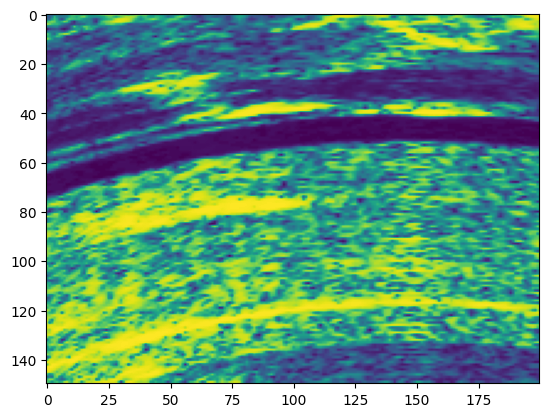

In [ ]:
plt.imshow(cv2.equalizeHist(x))